In [148]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

train_dataset = datasets.MNIST('./', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST('./', train=False, transform=transforms.ToTensor(), download=True)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True, drop_last=True)

100%|████████████████████████████| 9912422/9912422 [00:01<00:00, 8727894.87it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



100%|████████████████████████████████| 28881/28881 [00:00<00:00, 1727622.31it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|████████████████████████████| 1648877/1648877 [00:00<00:00, 2111424.06it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



100%|█████████████████████████████████| 4542/4542 [00:00<00:00, 13406424.19it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [149]:
device = torch.device("cuda")

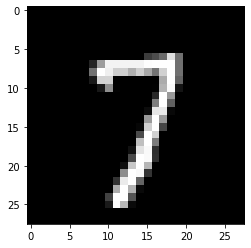

In [150]:
 def plot_img(image):
    image = image.numpy()[0]
    image = 255 * image
    plt.imshow(image, cmap='gray')

sample_data = next(iter(train_loader))
plot_img(sample_data[0][0])

# linear_model_2

In [288]:
model = nn.Sequential()
model.add_module('fc1', nn.Linear(28*28, 100))
model.add_module('relu1', nn.ReLU())
model.add_module('fc2', nn.Linear(100, 100))
model.add_module('relu2', nn.ReLU())
model.add_module('fc3', nn.Linear(100, 10))
model.to(device)

loss_fn = nn.CrossEntropyLoss() # softmax 함수 적용됨.
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

In [313]:
epochs = 50
val_loss_history = []
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for x, y in train_loader:
        x = x.view(-1, 28*28).to(device)
        y = y.to(device)
        optimizer.zero_grad()
        output = model(x)
        loss = loss_fn(output, y)
        loss.backward()
        optimizer.step()
        total_loss += loss
    avg_train_loss = total_loss / len(train_loader)
    
    total_loss = 0
    with torch.no_grad():
        model.eval()
        for test_x, test_y in test_loader:
            test_x = test_x.view(-1, 28*28).to(device)
            test_y = test_y.to(device)
            pred = model(test_x)
            total_loss += loss_fn(pred, test_y)
    avg_val_loss = total_loss / len(test_loader)
    val_loss_history.append(avg_val_loss.cpu().numpy())
    print(f"Epochs : {epoch+1}, train_loss : {avg_train_loss:.5f}, val_loss : {avg_val_loss:.5f}")

Epochs : 1, train_loss : 0.00089, val_loss : 0.08158
Epochs : 2, train_loss : 0.00072, val_loss : 0.08092
Epochs : 3, train_loss : 0.00064, val_loss : 0.08193
Epochs : 4, train_loss : 0.00061, val_loss : 0.08250
Epochs : 5, train_loss : 0.00053, val_loss : 0.08334
Epochs : 6, train_loss : 0.00048, val_loss : 0.08400
Epochs : 7, train_loss : 0.00045, val_loss : 0.08481
Epochs : 8, train_loss : 0.00042, val_loss : 0.08459
Epochs : 9, train_loss : 0.00039, val_loss : 0.08548
Epochs : 10, train_loss : 0.00037, val_loss : 0.08674
Epochs : 11, train_loss : 0.00034, val_loss : 0.08778
Epochs : 12, train_loss : 0.00033, val_loss : 0.08810
Epochs : 13, train_loss : 0.00031, val_loss : 0.08824
Epochs : 14, train_loss : 0.00030, val_loss : 0.08856
Epochs : 15, train_loss : 0.00028, val_loss : 0.08892
Epochs : 16, train_loss : 0.00027, val_loss : 0.08930
Epochs : 17, train_loss : 0.00026, val_loss : 0.08963
Epochs : 18, train_loss : 0.00025, val_loss : 0.08981
Epochs : 19, train_loss : 0.00024, va

In [315]:
val_loss_hisotry = np.array(val_loss_history)

# test_dataset의 예측값
preds2 = []
with torch.no_grad():
    model.eval()
    for x, y in test_loader:
        x = x.view(-1, 28*28).to(device)
        y = y.to(device)
        pred = model(x)
        preds2.append(np.argmax(pred.cpu().numpy(), axis=1))

In [320]:
test_ys = test_dataset.targets[:9984]
preds2 = np.array(preds2).flatten()

In [321]:
cm = confusion_matrix(test_ys, preds2)

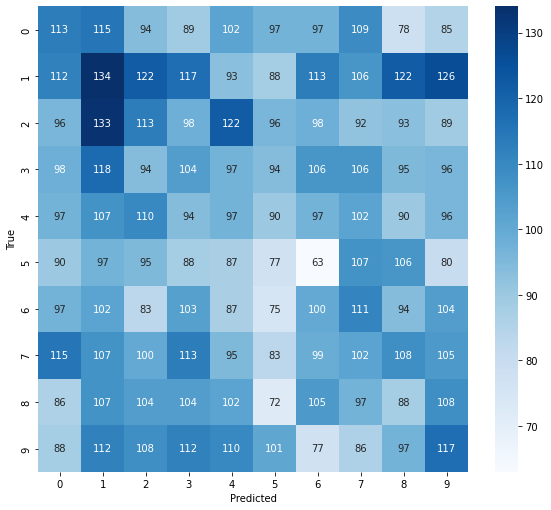

In [322]:
# heatmap value : 표본의 수
plt.figure(figsize=(8,7))
sns.heatmap(cm, annot=True,annot_kws={"size":10}, cmap='Blues', fmt="d")
plt.tight_layout()
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()